Populating the interactive namespace from numpy and matplotlib
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
<type 'dict'>
['__call__', '__class__', '__cmp__', '__delattr__', '__doc__', '__format__', '__func__', '__get__', '__getattribute__', '__hash__', '__init__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'im_class', 'im_func', 'im_self']
10001
10001


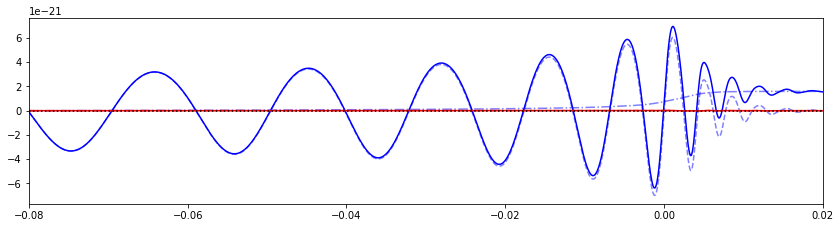

10001
10001
[  0.00000000e+00   1.00622611e-32   6.03817211e-32   1.81172054e-31
   4.02666396e-31   7.55117238e-31   1.26879633e-30   1.97399460e-30
   2.90102201e-30   4.08020750e-30]
[  6.46187265e-28   6.85570418e-28   7.26525561e-28   7.69083713e-28
   8.13275904e-28   8.59133182e-28   9.06686603e-28   9.55967235e-28
   1.00700615e-27   1.05983444e-27]
5001
5001
[ -0.00000000e+00  -4.56230844e-29  -1.96620759e-28  -4.74195428e-28
  -8.99562037e-28  -1.49394747e-27  -2.27858995e-27  -3.27473843e-27
  -4.50365199e-27  -5.98659921e-27]
[ -5.48470094e-25  -5.79855755e-25  -6.12409667e-25  -6.46152867e-25
  -6.81106374e-25  -7.17291184e-25  -7.54728274e-25  -7.93438597e-25
  -8.33443081e-25  -8.74762628e-25]
5001
5001


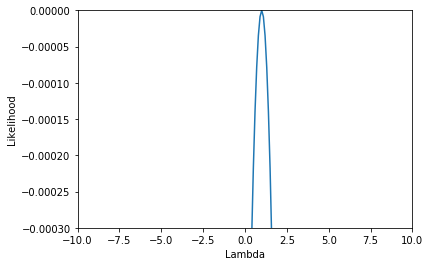

TypeError: 'function' object has no attribute '__getitem__'

In [30]:
mass = [60, 60, 60]
dist = [5, 50, 100]

def LambdaPeakGraph (mass, dist):
    %pylab inline
    %config Inline.Backend.figure_format = 'retina'

    #from __future__ import division, print_function
    import gwmemory
    !pip install lalsuite 

    from pycbc import catalog
    from pycbc.waveform import get_td_waveform, get_fd_waveform
    from pycbc.waveform import td_approximants, fd_approximants
    from pycbc.fft import fft

    import numpy as np
    import scipy as sp
    import pylab
    from scipy.fftpack import fft, rfft

    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.mlab as mlab
    from pycbc.filter import resample_to_delta_t, highpass
    from pycbc.catalog import Merger
    from pycbc.psd import interpolate, inverse_spectrum_truncation
    from pycbc.waveform import get_td_waveform
    from pycbc.filter.matchedfilter import match

    from scipy import signal
    from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
    import h5py
    import json
    import matplotlib.lines as mlines

    def InnerProduct(a, b, Sn, df):

        b_conj = np.conjugate(b)

        integrand = []

        for i in range(0,len(a)):
            intgrnd = a[i]*b_conj[i]/Sn[i]
            integrand.append(intgrnd)

        result_complex = 4*np.sum(integrand)*df

        result = np.real(result_complex)

        return result
    
    
    def LogLikelihood(data, h_theta, Sn, df):

        h_minus_d = h_theta - data

        term = (-1.0/2)*InnerProduct(h_minus_d, h_minus_d, Sn, df)

        result = (term)

        return result
    
  
      #In order to generate the memory we necessarily generate the time-domain oscillatory waveform
    q = 1.
    S1 = [0., 0., 0.]
    S2 = [0., 0., 0.]

    times = np.linspace(-0.08, 0.02, 10001)
    #times = np.linspace(-0.98, .01, 10000)
    surr = gwmemory.waveforms.Surrogate(q=q, S1=S1, S2=S2, MTot = mass, distance = dist, times=times)



    inc = np.pi / 2
    pol = 0

    oscillatory, times = surr.time_domain_oscillatory(inc=inc, pol=pol)
    memory, times = surr.time_domain_memory(inc=inc, pol=pol)

    fig = figure(figsize=(12, 6))
    fig.add_subplot(2, 1, 1)
    plot(times, oscillatory['plus'], linestyle='--', color='b', alpha=0.5)
    plot(times, oscillatory['cross'], linestyle='--', color='r', alpha=0.5)
    plot(times, memory['plus'], linestyle='-.', color='b', alpha=0.5)
    plot(times, memory['cross'], linestyle='-.', color='r', alpha=0.5)
    plot(times, oscillatory['plus'] + memory['plus'], color='b')
    plot(times, oscillatory['cross'] + memory['cross'], color='r')
    axhline(0, linestyle=':', color='k')
    xlim(-0.08, 0.02)

    print (type (oscillatory))

    print (dir(surr.time_domain_oscillatory))

    print (len(times))

    print (times.size)


    tight_layout()
    show()
    close()
    
    
    mem_plus = memory['plus']
    dt = times[1] - times[0]
    window = signal.tukey(len(mem_plus))
    win_mem= window*mem_plus
    print (len(win_mem))
    print(len(times))
    freq_mem = np.fft.rfft(win_mem)*dt

    dt = times[1] - times[0]
    #print (help(np.fft.fftfreq))
    fft_mem = np.fft.rfftfreq (len(win_mem),dt)                            
    print (win_mem[0:10])
    print (win_mem[50:60])
    print (len(freq_mem))
    print (len(fft_mem))



    osci_plus = oscillatory['plus']
    window = signal.tukey(len(osci_plus))
    win_osc= window*osci_plus
    freq_osc = np.fft.rfft(win_osc)*dt

    fft_osc = np.fft.rfftfreq(len(win_osc), dt)                            
    print (win_osc[0:10])
    print (win_osc[50:60])
    print (len(fft_osc))
    print (len(freq_osc))
    
    
    s = freq_osc + freq_mem

        #Making psd 
    merger = Merger("GW150914")
    
   
    # Get the data from the Hanford detector
    strain = merger.strain('H1')
    df = strain.delta_f
    psd = strain.psd(4)
    asd = np.sqrt(psd)
    asd_freqs = psd.sample_frequencies

        ##Interpolating to make  memory and oscillatory component (in freq domain) and PSD equal. This will line them up
    from scipy.interpolate import interp1d
    sampfreq = 4096
    datafreq = np.fft.fftfreq(freq_osc.size)*sampfreq
    interpolate_psd = np.interp(datafreq, asd_freqs, psd)

    #Template, adding in the lambda component. Will store log likelihood of the template
    lambda_arr = np.arange(-10,10,.1)
    like_arr = []
    for weight in lambda_arr:
        h_trial = freq_osc + weight*freq_mem
        like_trial = LogLikelihood(s, h_trial, interpolate_psd, df)
        like_arr.append(like_trial)
        
            #Plotting the normalized likelihood array
    import pylab
    import numpy

    x = lambda_arr 
    y = np.asarray(like_arr)
    #pylab.semilogy(x,y) 
    pylab.plot(x,y)
    pylab.xlim(-10, 10, 0.01)
    pylab.xlabel('Lambda')
    pylab.ylim(-.0003, .000, 0.001)
    pylab.ylabel('Likelihood')
    #plt.title("Likelihood for 60 solar massess and 5 megaparsecs", y=1.08)

    pylab.show() 
    
    
for i in range(2):
    #for i in range(0, len(mass)):
    LambdaPeakGraph(mass[i], dist[j])
        
        
        
    